Matteo Picciolini

# Esercitazione 12 - Esercizio 12.1

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import activations
from tensorflow.keras import backend as K

seed = 0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

2023-06-26 16:48:26.804263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:48:26.849073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:48:26.849935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 16:48:27.609817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Exercise 12.1

Change at will and train your DNN by increasing the number of epochs to an adeuqate value. Try to use at least two other optimizers, different from SGD: watch to accuracy and loss for training and validation data and comment on the performances.

### Risoluzione 
Per svolgere questo esercizio parto dal codice che è stato fornito a lezione. Dopodiché modifico il numero di epoche e l'ottimizzatore per trovare una combinazione dei parametri soddisfacente.

##### Inizializzazione della rete

`Keras` ha la capacità di scaricare comodamente i dati `MNIST` dal web. Per farlo, basta importare il modulo `mnist` e utilizzare il metodo `load_data`, e verrà generato il set di dati di addestrametno e di test.

`MNIST` ha set di test e di addestramento predefiniti, al fine di facilitare il confronto delle prestazioni dei diversi modelli sui dati.

Una volta caricati i dati, li formatto nella forma corretta.

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)


##### Riformattazione dei dati
Il codice seguente prepara i dati per l'addestramento di un modello di reti neurali normalizzando i valori dei pixel, ridimensionando le dimensioni dei dati e codificando le etichette di classe in modo categorico.

In [3]:
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('Before to_categorical: ')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('After to_categorical: ')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

Before to_categorical: 
X_train shape: (60000, 784)
X_test shape: (10000, 784)
After to_categorical: 
X_train shape: (60000, 784)
Y_train shape: (60000, 10)


##### Rete neurale
Procedo ora con la costruzione della rete neurale. Utilizzo la classe `Sequential` di `Keras` per istanziare un modello e aggiungo gradualmente diversi strati utilizzando il metodo `add`.

Ogni livello `Dense` accetta come suo primo argomento obbligatorio un numero intero che specifica il numero di neuroni. Il tipo di funzione di attivazione per il livello viene definito utilizzando l'argomento opzionale `activation`. Alcuni esempi di funzione di attivazione sono: `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.

In questo modello si utilizza la tecnica di *dropout*, tecnica utilizzata durante l'addestramento delle reti neurali per ridurre il problema dell'*overfitting*. Durante l'addestramento, il *dropout* disattiva casualmente alcuni neuroni artificiali in modo che non contribuiscano all'elaborazione dei dati in quel determinato passaggio. Ciò impone alla rete di trovare soluzioni più robuste, riducendo la dipendenza e l'interdipendenza tra i neuroni. Questo può portare a un calo dell'accuratezza durante l'addestramento perché alcuni neuroni vengono temporaneamente rimossi, ma allo stesso tempo aiuta a prevenire l'overfitting e a migliorare la capacità di generalizzazione del modello.

Durante la fase di *test*, invece, il *dropout* viene disattivato e tutti i neuroni vengono utilizzati per l'elaborazione dei dati. Ciò consente al modello di beneficiare di tutti i classificatori deboli presenti nella rete neurale, che sono stati allenati con diversi sottoinsiemi dei dati durante l'addestramento. Di conseguenza, l'accuratezza durante il testing può migliorare rispetto all'addestramento, in quanto il modello può combinare in modo efficace le predizioni di tutti i classificatori deboli per ottenere risultati migliori su nuovi dati che non sono stati utilizzati durante l'addestramento.

In [4]:
def create_DNN():
    model = Sequential()
    model.add(Dense(400, input_shape = (img_rows * img_cols,), activation = 'relu')) 

    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

Si noti l'utilizzo della funzione di attivazione `softmax` nell'ultimo *layer*. Questa funzione è nota anche come funzione esponenziale normalizzata, è una funzione che prende in input un vettore di K numeri reali e lo normalizza in una distribuzione di probabilità composta da K probabilità. Prima di applicare la funzione `softmax`, alcune componenti del vettore potrebbero essere negative o superiori a uno e la somma delle componenti potrebbe non essere uguale a 1. Dopo l'applicazione di `softmax`, ogni componente si trova nell'intervallo $(0,1)$ e la somma delle componenti sarà 1, in modo che possano essere interpretate come probabilità.

#### Compilazione del modello

Per i problemi di classificazione, la funzione di costo migliore è la *cross entropy*. Poiché i dati di output sono convertiti nel formato categorico, scegliamo la funzione `categorical_crossentropy` definita nel modulo `losses` di Keras. 

In generale, a seconda del problema di interesse, è possibile scegliere una funzione di costo appropriata. 

Per ottimizzare i pesi della rete, è necessario scegliere l'ottimizzatore. Alcuni esempi di ottimizzatore sono `sgd`, `adam`, `adagrad` e `RMSprop`. Questi algoritmi sono già disponibili nel modulo `optimizers` di Keras.

In [5]:
def compile_model():
    # create the model
    model = create_DNN()
    # compile the model
    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = 'adagrad',
                  metrics = ['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Addestramento della rete
Addestro ora il modello per un certo numero di epoche. Ogni epoca corrisponde all'utilizzo di tutti i dati di addestramento divisi in minibatch.

In [6]:
my_batch_size = 32
epochs = 15

model_DNN = compile_model()

history = model_DNN.fit(X_train, Y_train,
                        batch_size = my_batch_size,
                        epochs = epochs,
                        verbose = 1,
                        validation_data = (X_test, Y_test)
                        )

Epoch 1/15


2023-06-26 16:48:29.257402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1875/1875 [==============================] - 11s 6ms/step - loss: 1.3076 - acc: 0.6141 - val_loss: 0.6282 - val_acc: 0.8644
Epoch 2/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6976 - acc: 0.7988 - val_loss: 0.4415 - val_acc: 0.8947
Epoch 3/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5694 - acc: 0.8348 - val_loss: 0.3760 - val_acc: 0.9048
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5090 - acc: 0.8531 - val_loss: 0.3410 - val_acc: 0.9110
Epoch 5/15
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4643 - acc: 0.8673 - val_loss: 0.3169 - val_acc: 0.9150
Epoch 6/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4366 - acc: 0.8760 - val_loss: 0.2990 - val_acc: 0.9179
Epoch 7/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4126 - acc: 0.8822 - val_loss: 0.2841 - val_acc: 0.9218
Epoch 8/15
1875/1875 [==============================] - 10s 5ms/ste

#### Risultati

313/313 [==============================] - 1s 2ms/step - loss: 0.2245 - acc: 0.9358

Test loss: 0.22453372180461884
Test accuracy: 0.9358000159263611


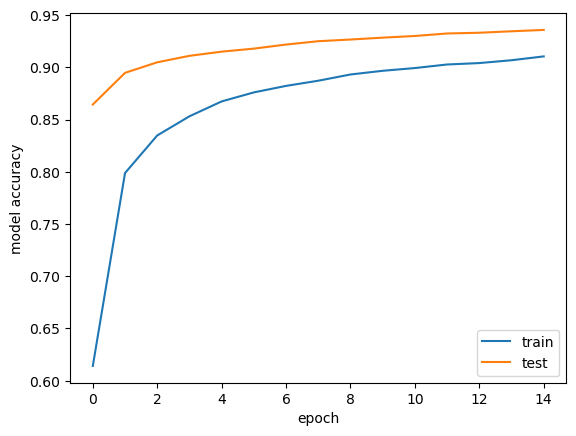

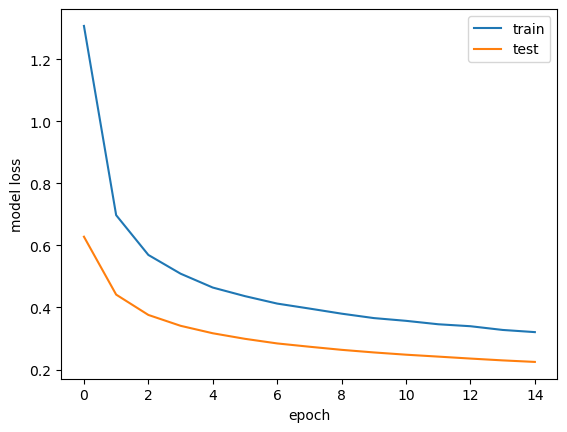

In [7]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

313/313 [==============================] - 1s 3ms/step


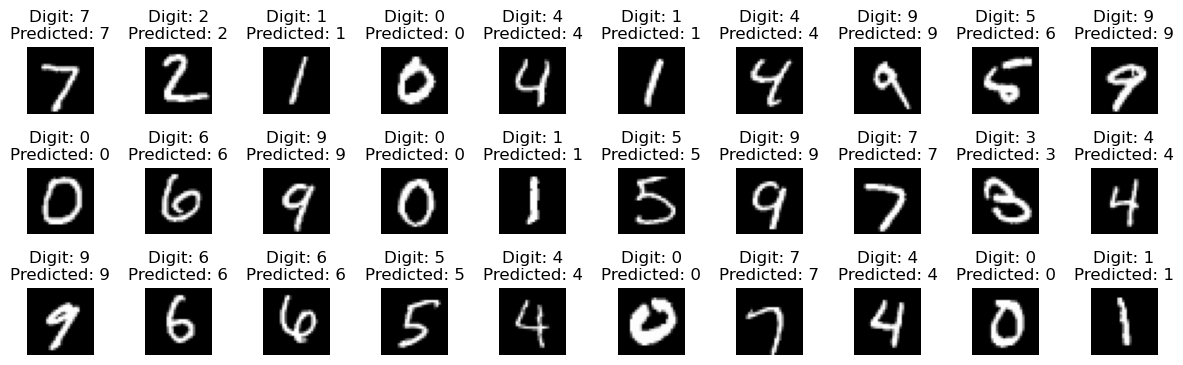

In [8]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize = (15,4))
for i in range(30):    
    ax = plt.subplot(3, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap = 'gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
    plt.subplots_adjust(hspace = 0.8)
plt.show()

#### Conclusioni
Dopo vari test con i quattro ottimizzatori che ho riportato sopra e con il numero di epoche, concludo che i risultati migliori per questo specifico problema li ho ottenuti con l'ottimizzatore `adagrad` e un numero di epoche maggiore di 8. Ho potuto notare come l'ottimizzatore `sdg` sia molto più rapido degli altri ottimizzatori, anche se in termini di *loss* e *accuracy* retituisce risultati peggiori a parità di numero di epoche. 

In generale, con un numero di epoche inferiore a 8 i risultati non sono particolarmente buoni, ad esclusione dei casi realizzati con gli ottimizzatori `nadam` e `adam`, da cui si ottengono ottimi risultati anche dopo poche epoche. Con questi due ottimizzatori, però, il modello sembra andare subito  in *overfitting* dopo poche epoche, infatti il grafico della *loss* per il set di *test* tendere a rimandere costante.